# **CNN model for flower data**

# **4. Build your own dataset by collecting images from the internet**

Here, I have downloaded flower image.

# **Imported required libraries**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from keras.models import Model
from keras.models import load_model

# **Download the data**

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

 ### **There are 3,670 total images:**

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


# **Print sample image from rose category**

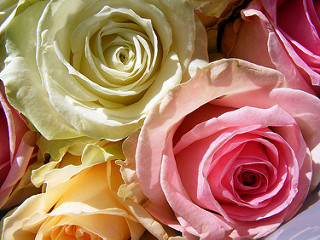

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[5]))

# **Print sample image from Tulips category**

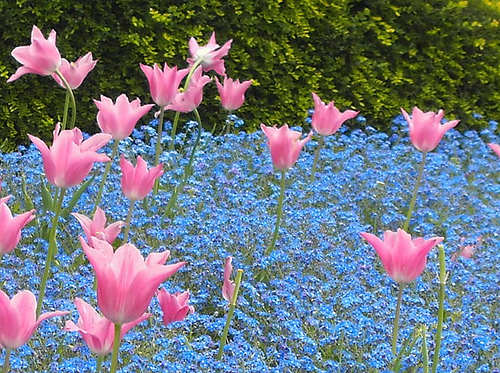

In [5]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[2]))

# **Load using keras.preprocessing**

Load these images off disk using the helpful image_dataset_from_directory utility.

**Create a dataset**

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

### **Use a validation split while building model. Here using 80% of the images for training, and 20% for validation.**

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


**Find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.**

In [9]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


# **Visualize the data**

Here are the first 9 images from the training dataset.

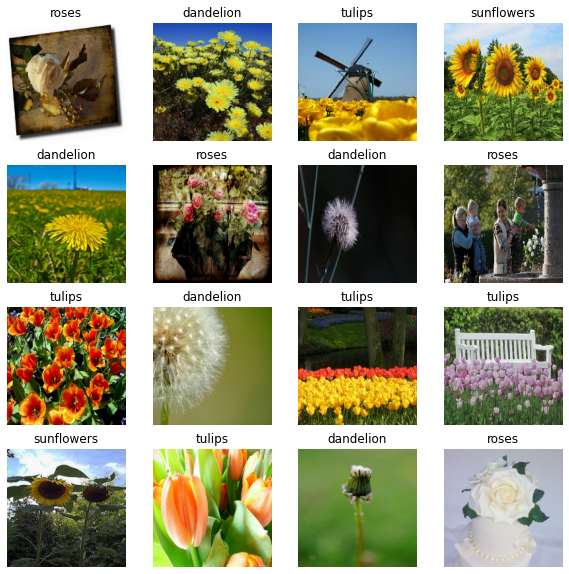

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# **Configure the dataset for performance**

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training  model. If dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

Dataset.prefetch() overlaps data preprocessing and model execution while training.


In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# **Train the model on your dataset and report the accuracy**

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a relu activation function.

In [12]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [15]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 12s 60ms/step - loss: 1.3502 - accuracy: 0.4040 - val_loss: 1.2127 - val_accuracy: 0.4796
Epoch 2/10
92/92 [==============================] - 4s 44ms/step - loss: 0.9881 - accuracy: 0.6121 - val_loss: 0.9612 - val_accuracy: 0.6240
Epoch 3/10
92/92 [==============================] - 4s 42ms/step - loss: 0.7764 - accuracy: 0.7050 - val_loss: 0.8954 - val_accuracy: 0.6540
Epoch 4/10
92/92 [==============================] - 4s 42ms/step - loss: 0.5737 - accuracy: 0.7868 - val_loss: 0.8855 - val_accuracy: 0.6757
Epoch 5/10
92/92 [==============================] - 4s 43ms/step - loss: 0.3106 - accuracy: 0.8951 - val_loss: 1.0284 - val_accuracy: 0.6526
Epoch 6/10
92/92 [==============================] - 4s 42ms/step - loss: 0.1714 - accuracy: 0.9452 - val_loss: 1.2848 - val_accuracy: 0.6431
Epoch 7/10
92/92 [==============================] - 4s 42ms/step - loss: 0.1074 - accuracy: 0.9700 - val_loss: 1.4155 - val_accuracy: 0.6308
Epoch 8/10
9

In [16]:
# Model evaluation
scores = model.evaluate(val_ds, verbose=0)
print("Test Accuracy for Image classification model: %.2f%%" % (scores[1]*100))

Test Accuracy for Image classification model: 62.94%


# **Plot the training and validation accuracy**

Create plots of loss and accuracy on the training and validation sets.

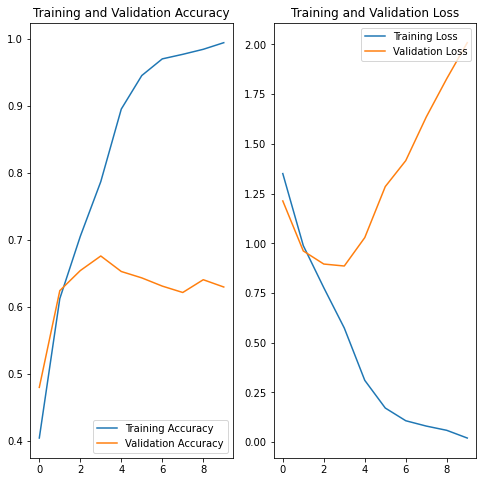

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observation**: From the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around 60% accuracy on the validation set. In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of overfitting.


# **Save the model as a file and load the model again and predict on some images.**

In [18]:
# TODO: Save your trained model as a Keras model.
# The name of our HDF5 will correspond to the current time stamp.
import time
t = time.time()

export_path_keras = "./{}.h5".format(int(t))
print(export_path_keras)

model.save(export_path_keras)

./1636598380.h5


In [19]:
import tensorflow_hub as hub

In [20]:
# TODO: Load the Keras model
reloaded = tf.keras.models.load_model(
  export_path_keras, 
  # `custom_objects` tells keras how to load a `hub.KerasLayer`
  custom_objects={'KerasLayer': hub.KerasLayer})

reloaded.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

# **Predict images after loading data**

Here, i am predicting 1 to 4 range of rose category

In [21]:
from keras.preprocessing import image
# Get test image ready

for i in range(5):
  test_image = image.load_img(roses[i], target_size=(img_width, img_height))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis=0)

  test_image.reshape(img_width, img_height, 3) 

  result = model.predict(test_image, batch_size=1)
  print (result)

[[ 1.8736271 -6.580345  10.980469  -7.199899   0.2573201]]
[[  3.417398  -8.591465  16.963541 -11.567641   2.650925]]
[[-1.9218059 -1.2552048 10.404164  -9.802591   2.0374873]]
[[ -1.22053     -0.60956633  18.02725    -13.194705     0.9872976 ]]
[[ 0.2048081 -1.0033623 14.419045  -5.323444  -3.8415308]]


In [22]:
print(class_names[int(result[0][0])])

daisy
